# Phase 1

[INFO] Reading Excel: /kaggle/input/centrifugal-compressors/centrifugal_compressor.xlsx

Raw Data Snapshot
               Timestamp  75ZI800BA.pv  75ZI800BB.pv  75ZI801BA.pv  75ZI801BB.pv  75PI808.pv  75PI823.pv  75PI870.pv  75PI845.pv  75PDI853.pv  75TI821.pv  75TI822.pv  75TI827.pv  75TI828.pv  75TI824.pv  75TI829.pv  75TI830.pv  75TI831.pv  75TI832.pv  75TI836.pv  75TI834.pv  75XI821BX.pv  75XI822BY.pv  75XI823BX.pv  75XI824BX.pv  75SI865R.pv
  0  2022-01-01 00:00:00      0.045518     -0.006139     -0.087505     -0.075875    9.914831    2.554831    8.464686    4.770698     1.986695   55.686024   61.253983   55.525040   62.286942   63.023968   62.627605   61.726616   73.597015   91.526245   70.804878   74.142601     11.888792      6.169401      6.175124      9.980923  6116.632194
  1  2022-01-01 00:15:00      0.046119     -0.005792     -0.087413     -0.075961    9.929470    2.558367    8.477184    4.770698     2.006444   55.501453   61.094116   55.365475   61.981060   62.660980   62.

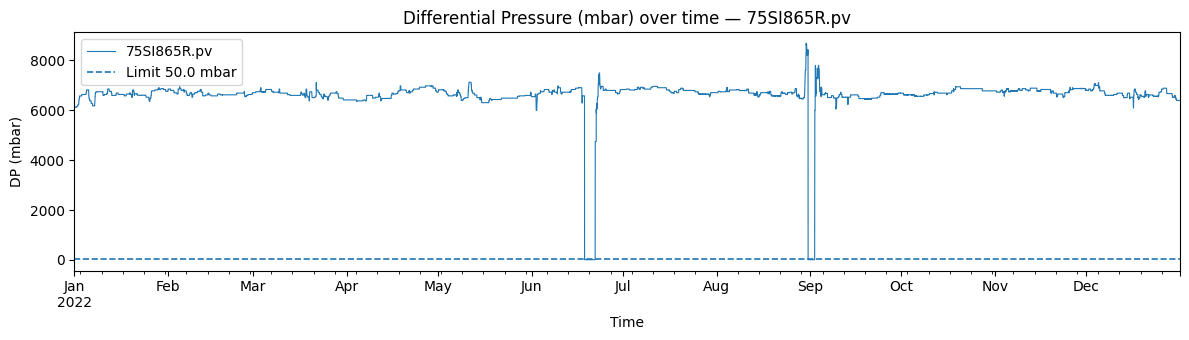

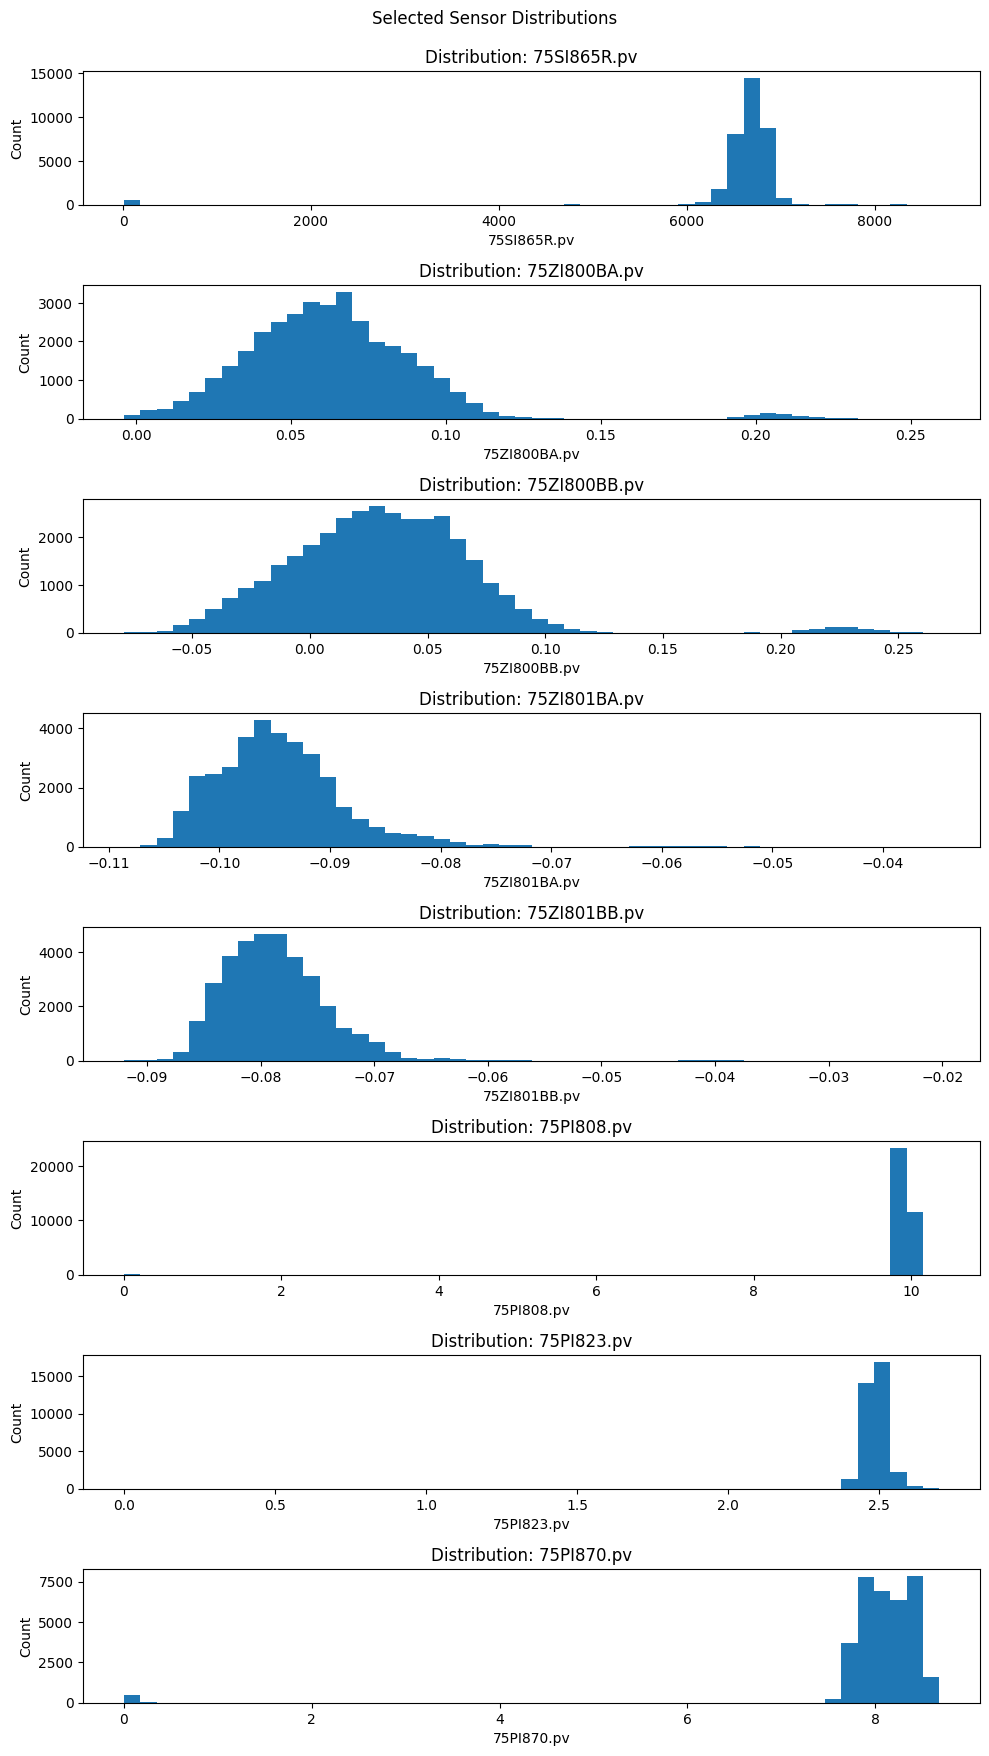

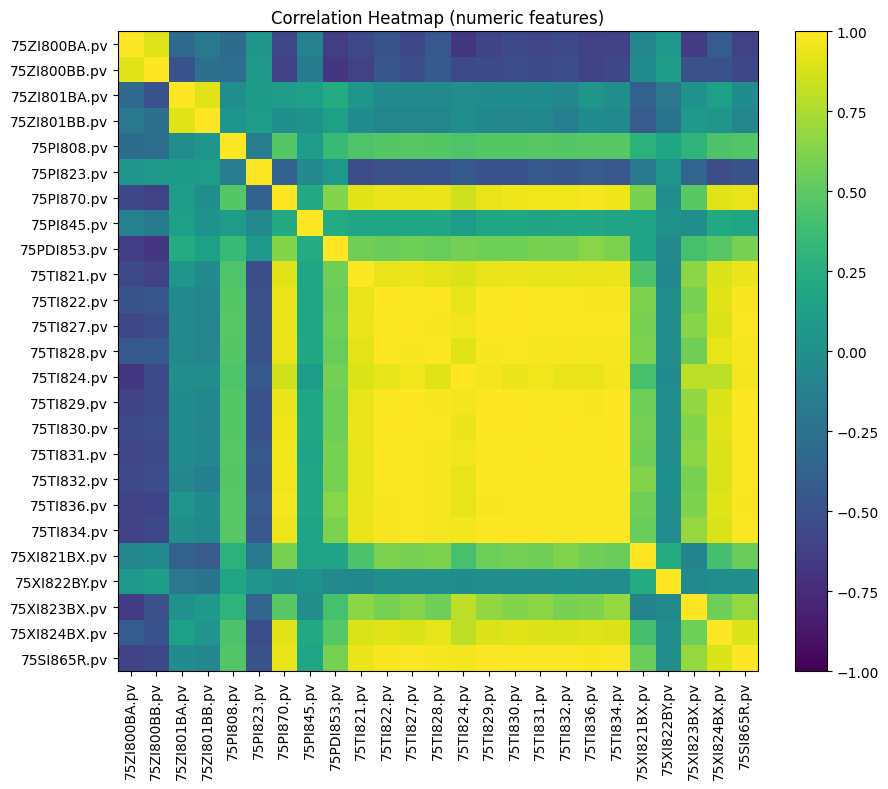

In [1]:
# ============================================================
# PHASE 0 — Setup, Robust Data Loading, Validation, Baseline EDA
# (Kaggle-ready; fixes DataFrame.mad() error and minor typos)
# ============================================================

# -----------------
# 0) Imports
# -----------------
import os, re, json, warnings, textwrap
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# -----------------
# 1) Config
# -----------------
CONFIG = {
    "DATA_PATH": "/kaggle/input/centrifugal-compressors/centrifugal_compressor.xlsx",
    "OUT_DIR": "./outputs",
    "FIG_DIR": "./outputs/figures",
    "ARTIFACT_DIR": "./outputs/artifacts",
    "RANDOM_STATE": 42,
    "EXPECTED_FREQ": "15min",
    # Units and thresholds
    # If your DP is in bar (rare), set DP_UNIT="bar" and DP_MBAR_MULT=1000.0
    "DP_UNIT": "mbar",
    "DP_MBAR_MULT": 1.0,   # set to 1000.0 if original DP is in bar
    # DP limit (for later phases — can be tuned once aligned with ops)
    "DP_LIMIT_MBAR": 50.0,  # placeholder; we will calibrate later
    # Plot defaults
    "FIG_DPI": 300,
}

np.random.seed(CONFIG["RANDOM_STATE"])

# Prepare output dirs
Path(CONFIG["OUT_DIR"]).mkdir(parents=True, exist_ok=True)
Path(CONFIG["FIG_DIR"]).mkdir(parents=True, exist_ok=True)
Path(CONFIG["ARTIFACT_DIR"]).mkdir(parents=True, exist_ok=True)

def _savefig(name: str):
    path = f'{CONFIG["FIG_DIR"]}/{name}.png'
    plt.tight_layout()
    plt.savefig(path, dpi=CONFIG["FIG_DPI"], bbox_inches="tight")
    print(f"[FIG] Saved: {path}")

def _qa_print(title: str, content: str):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    print(textwrap.indent(content, "  "))

# -----------------
# 2) Load Excel
# -----------------
print("[INFO] Reading Excel:", CONFIG["DATA_PATH"])
df_raw = pd.read_excel(CONFIG["DATA_PATH"])

_qa_print("Raw Data Snapshot", df_raw.head(3).to_string())

# -----------------
# 3) Identify timestamp column robustly
# -----------------
def detect_datetime_column(df: pd.DataFrame):
    # Common names first
    candidates = [c for c in df.columns
                  if re.search(r"time|timestamp|date|datetime", str(c), re.I)]
    # If not found, try first column that parses as datetime
    parsed_ok = None
    if not candidates:
        for c in df.columns:
            try:
                pd.to_datetime(df[c].iloc[:20], errors="raise")
                parsed_ok = c
                break
            except Exception:
                continue
        if parsed_ok:
            candidates = [parsed_ok]
    return candidates[0] if candidates else None

ts_col = detect_datetime_column(df_raw)
if ts_col is None:
    raise ValueError(
        "No datetime-like column found. Please rename your time column to include "
        "one of: time, timestamp, date, datetime."
    )

print(f"[INFO] Using datetime column: {ts_col}")
df = df_raw.copy()
df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
if df[ts_col].isna().any():
    n_bad = df[ts_col].isna().sum()
    raise ValueError(f"{n_bad} rows have non-parsable timestamps in column {ts_col}.")

# Set index and sort
df = df.set_index(ts_col).sort_index()
_qa_print("Index Range", f"{df.index.min()}  →  {df.index.max()}  (n={len(df)})")

# -----------------
# 4) Identify Differential Pressure (DP) column robustly
#     (Fix: compute variability without DataFrame.mad())
# -----------------
def detect_dp_column(df: pd.DataFrame):
    # Heuristics: names containing PDI (diff press instrument), DP, PDT, or 'diff' near 'press'
    name_pat = re.compile(r"(?:\bPDI\b|\bPDT\b|diff.*press|delta.*press|\bdp\b)", re.I)
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    # Prioritize obvious names
    pri = [c for c in num_cols if name_pat.search(str(c))]
    if pri:
        # Prefer exact "PDI" matches then others
        pdi = [c for c in pri if re.search(r"\bPDI\b", str(c), re.I)]
        if pdi:
            return pdi[0]
        return pri[0]
    # Fallback: pick the numeric column with highest robust variability (Median Absolute Deviation proxy)
    if not num_cols:
        return None
    med = df[num_cols].median()
    mad_series = (df[num_cols].sub(med)).abs().median()  # robust dispersion per column
    mad_series = mad_series.sort_values(ascending=False)
    cand = mad_series.index[0] if len(mad_series) else None
    return cand

dp_col = detect_dp_column(df)
if dp_col is None:
    raise ValueError(
        "Could not infer a DP (differential pressure) column. "
        "Please specify it manually in CONFIG as DP_COL."
    )

print(f"[INFO] Inferred DP column: {dp_col}")

# -----------------
# 5) Basic cleaning & frequency enforcement
# -----------------
# Ensure strictly increasing, drop duplicates
before = len(df)
df = df[~df.index.duplicated(keep="first")]
after = len(df)
if after < before:
    print(f"[WARN] Dropped {before-after} duplicate timestamp rows.")

# Enforce expected 15-min cadence
df = df.asfreq(CONFIG["EXPECTED_FREQ"])
missing = df.isna().sum().sum()
if missing > 0:
    # Minimal imputation: forward-fill, then back-fill for leading gaps
    df = df.ffill().bfill()
    print(f"[INFO] Filled {missing} missing values via ffill/bfill after asfreq().")

# DP unit conversion to mbar if needed
if CONFIG["DP_UNIT"].lower() == "bar":
    df[dp_col] = df[dp_col] * CONFIG["DP_MBAR_MULT"]
    print(f"[INFO] Converted DP from bar to mbar using factor {CONFIG['DP_MBAR_MULT']}.")

# -----------------
# 6) Sanity checks
# -----------------
checks = []
checks.append(f"Monotonic index: {df.index.is_monotonic_increasing}")
checks.append(f"Frequency set to: {pd.infer_freq(df.index) or 'irregular'} (expected {CONFIG['EXPECTED_FREQ']})")
if (df[dp_col] < 0).any():
    nneg = int((df[dp_col] < 0).sum())
    checks.append(f"[WARN] DP has {nneg} negative samples (should be non-negative).")
else:
    checks.append("DP non-negativity: OK")

# Nulls after cleaning
null_counts = int(df.isna().sum().sum())
checks.append(f"Total missing values after cleaning: {null_counts}")

_qa_print("Data QA Summary", "\n".join(checks))

# Save a data dictionary
dtypes = df.dtypes.astype(str)
desc = df.describe(include="all").T
data_dict = pd.concat([dtypes.rename("dtype"), desc], axis=1)
data_dict_path = f'{CONFIG["ARTIFACT_DIR"]}/data_dictionary.csv'
data_dict.to_csv(data_dict_path)
print(f"[ARTIFACT] Saved data dictionary → {data_dict_path}")

# Persist a lightweight manifest
manifest = {
    "config": CONFIG,
    "n_rows": int(len(df)),
    "n_cols": int(df.shape[1]),
    "index_start": str(df.index.min()),
    "index_end": str(df.index.max()),
    "dp_column": dp_col,
    "columns": df.columns.tolist(),
}
manifest_path = f'{CONFIG["ARTIFACT_DIR"]}/manifest.json'
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2, default=str)
print(f"[ARTIFACT] Saved manifest → {manifest_path}")

# -----------------
# 7) Baseline EDA (quick visuals)
# -----------------
plt.figure(figsize=(12, 3.5))
df[dp_col].plot(linewidth=0.8)
plt.title(f"Differential Pressure (mbar) over time — {dp_col}")
plt.xlabel("Time")
plt.ylabel("DP (mbar)")
plt.axhline(CONFIG["DP_LIMIT_MBAR"], linestyle="--", linewidth=1.2, label=f"Limit {CONFIG['DP_LIMIT_MBAR']} mbar")
plt.legend(loc="upper left")
_savefig("01_dp_timeseries")

# Distributions: DP and a few key numeric columns
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
sample_cols = [dp_col] + [c for c in num_cols if c != dp_col][:7]  # cap to 8 for readability
fig, axes = plt.subplots(len(sample_cols), 1, figsize=(10, 2.2*len(sample_cols)))
if len(sample_cols) == 1:
    axes = [axes]
for ax, c in zip(axes, sample_cols):
    ax.hist(df[c].dropna().values, bins=50)
    ax.set_title(f"Distribution: {c}")
    ax.set_xlabel(c)
    ax.set_ylabel("Count")
fig.suptitle("Selected Sensor Distributions", y=0.995)
plt.tight_layout()
_savefig("02_distributions")

# Correlation heatmap (numeric only, vanilla matplotlib)
corr = df[num_cols].corr().clip(-1, 1)
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation Heatmap (numeric features)")
plt.tight_layout()
_savefig("03_correlation_heatmap")

# Quick print of DP stats for eyeballing units
dp_stats = df[dp_col].describe(percentiles=[0.01,0.05,0.5,0.95,0.99]).to_string()
_qa_print("DP (mbar) Summary Stats", dp_stats)

# -----------------
# 8) Persist cleaned base data for next phases
# -----------------
parquet_path = f'{CONFIG["ARTIFACT_DIR"]}/base_timeseries.parquet'
try:
    df.to_parquet(parquet_path)
    print(f"[ARTIFACT] Saved cleaned base data → {parquet_path}")
except Exception as e:
    # Fallback to CSV if parquet engine is missing
    csv_path = f'{CONFIG["ARTIFACT_DIR"]}/base_timeseries.csv'
    df.to_csv(csv_path)
    print(f"[ARTIFACT] Parquet save failed ({e}). Fallback CSV saved → {csv_path}")

print("\n[PHASE 0 DONE] ✅  Loaded, validated, and profiled the dataset.")
print("If DP magnitudes look like 0.03–0.08, set DP_UNIT='bar' and DP_MBAR_MULT=1000.0 and re-run.")

# Phase 2

[WARN] Overriding DP column from '75SI865R.pv' → '75PDI853.pv' (detected true differential pressure).
[INFO] DP column in use: 75PDI853.pv
[INFO] Split sizes: train=17376 val=8832 test=8832
[INFO] Engineered features: total=525, dropped=356, kept=169
[ARTIFACT] Saved engineered features → ./outputs/artifacts/features_phase2.parquet  (shape=(35040, 198))
[ARTIFACT] Updated manifest with Phase 2 metadata.
[FIG] Saved: ./outputs/figures/04_dp_and_baseline.png
[FIG] Saved: ./outputs/figures/05_dp_auc_cumulative.png
[FIG] Saved: ./outputs/figures/06_regimes_over_time.png
[FIG] Saved: ./outputs/figures/07_key_boxplots.png

[PHASE 2 DONE] ✅  Feature set created, DP-AUC proxy computed, regimes tagged, splits defined.
Artifacts:
 - features_phase2.parquet
 - manifest.json (updated)
Figures:
 - 04_dp_and_baseline.png
 - 05_dp_auc_cumulative.png
 - 06_regimes_over_time.png
 - 07_key_boxplots.png


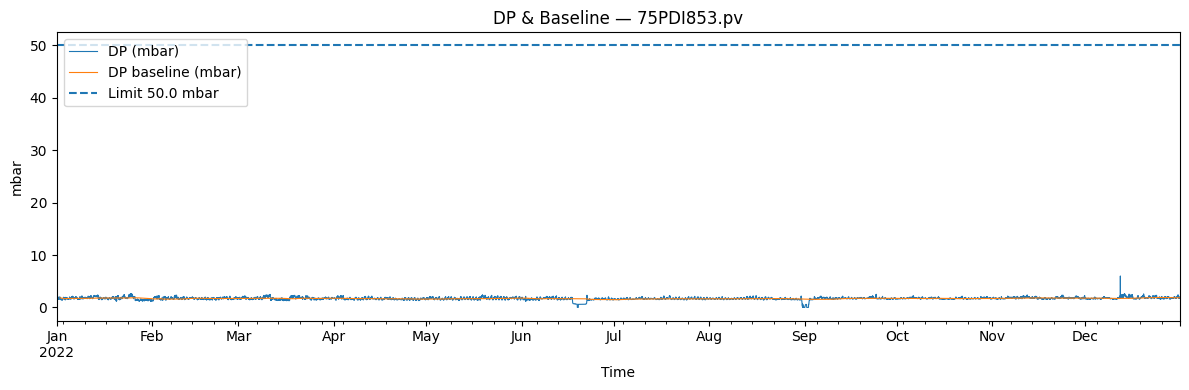

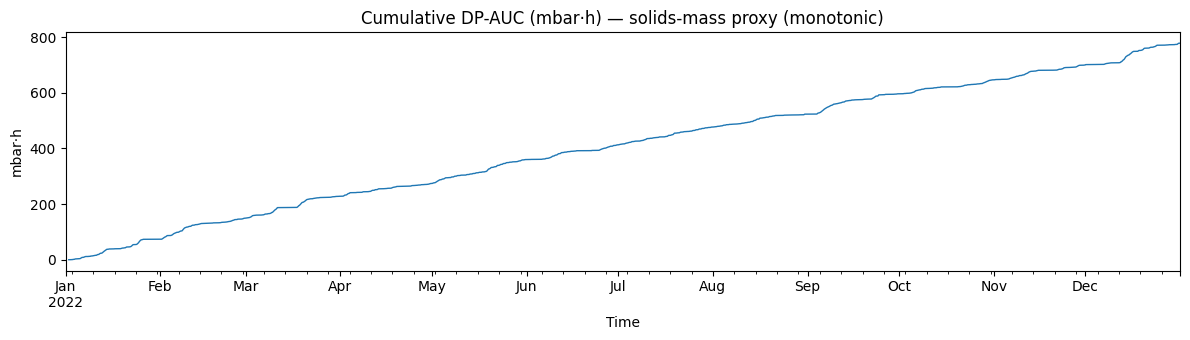

<Figure size 1200x280 with 0 Axes>

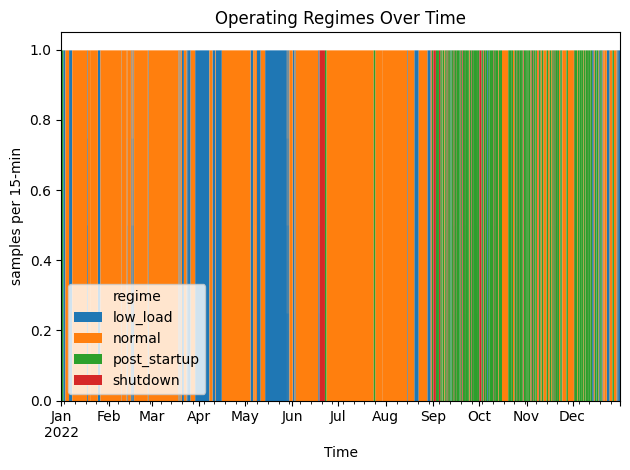

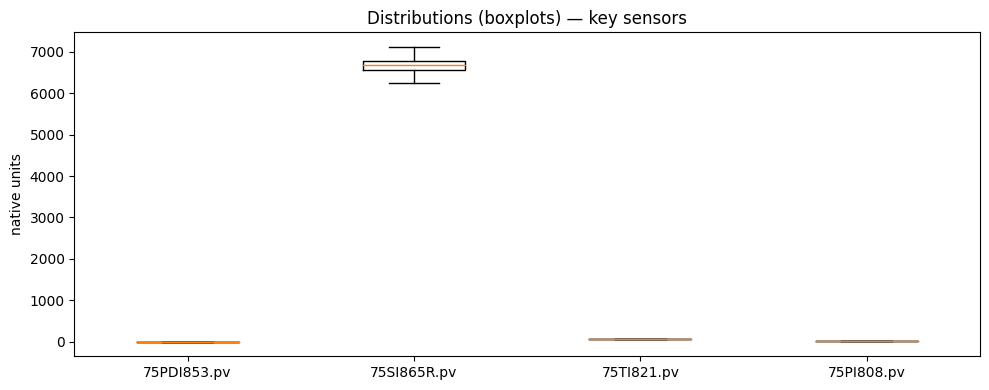

In [2]:
# ============================================================
# PHASE 2 — Causal Feature Engineering, DP-AUC Proxy, Regimes
# and Train/Val/Test splits with serialized artifacts
# ============================================================

import os, json, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

warnings.filterwarnings("ignore")

# -----------------
# 0) Load Phase 1 artifacts
# -----------------
ARTIFACT_DIR = "./outputs/artifacts"
FIG_DIR = "./outputs/figures"
Path(ARTIFACT_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

with open(f"{ARTIFACT_DIR}/manifest.json", "r") as f:
    manifest = json.load(f)

CONFIG = manifest["config"]
FIG_DPI = CONFIG.get("FIG_DPI", 300)
EXPECTED_FREQ = CONFIG.get("EXPECTED_FREQ", "15min")
DP_LIMIT_MBAR = CONFIG.get("DP_LIMIT_MBAR", 50.0)

def _savefig(name: str):
    plt.tight_layout()
    path = f"{FIG_DIR}/{name}.png"
    plt.savefig(path, dpi=FIG_DPI, bbox_inches="tight")
    print(f"[FIG] Saved: {path}")

# Load cleaned base data
df = pd.read_parquet(f"{ARTIFACT_DIR}/base_timeseries.parquet")

# -----------------
# 1) Fix DP column if Phase 1 mis-detected it
# -----------------
dp_col_manifest = manifest.get("dp_column")
true_dp_candidates = [c for c in df.columns if str(c).lower() in {"75pdi853.pv", "pdi853", "dp", "75pdi853"}]
if true_dp_candidates:
    dp_col = true_dp_candidates[0]
    if dp_col != dp_col_manifest:
        print(f"[WARN] Overriding DP column from '{dp_col_manifest}' → '{dp_col}' (detected true differential pressure).")
        manifest["dp_column"] = dp_col
else:
    # Fall back to manifest if we don't see a canonical DP name
    dp_col = dp_col_manifest
    print(f"[INFO] Using DP column from manifest: {dp_col}")

# A sanity print
print(f"[INFO] DP column in use: {dp_col}")

# -----------------
# 2) Global constants for windows and lags (causal only)
# -----------------
W_SHORT = 8    # 2 hours @15-min
W_MED   = 32   # 8 hours
W_LONG  = 96   # 24 hours
LAGS    = [1, 4, 8]  # 15 min, 1 hr, 2 hr
DT_HOURS = 0.25      # 15-min steps

# -----------------
# 3) DP baseline & DP-AUC solids-mass proxy
# -----------------
# Baseline: robust rolling median over 14 days, then smoothed with 1-day median
dp_baseline = (
    df[dp_col]
    .rolling(int(pd.Timedelta("14D") / pd.Timedelta(EXPECTED_FREQ)), min_periods=int(24*4))
    .median()
    .rolling(int(pd.Timedelta("1D") / pd.Timedelta(EXPECTED_FREQ)), min_periods=4)
    .median()
)
dp_excess = (df[dp_col] - dp_baseline).clip(lower=0)
dp_auc_cum = (dp_excess * DT_HOURS).cumsum()  # mbar·h cumulative

df_feat = df.copy()
df_feat["dp_baseline_mbar"] = dp_baseline
df_feat["dp_excess_mbar"] = dp_excess
df_feat["dp_auc_cum_mbar_h"] = dp_auc_cum

# -----------------
# 4) Causal rolling features (means, stds, peak-to-peak, slope)
# -----------------
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
def add_roll_features(frame: pd.DataFrame, cols, w: int, tag: str):
    out = {}
    for c in cols:
        s = frame[c]
        out[f"{c}_mean_w{w}"] = s.rolling(w, min_periods=max(2, w//2)).mean()
        out[f"{c}_std_w{w}"]  = s.rolling(w, min_periods=max(2, w//2)).std()
        out[f"{c}_min_w{w}"]  = s.rolling(w, min_periods=max(2, w//2)).min()
        out[f"{c}_max_w{w}"]  = s.rolling(w, min_periods=max(2, w//2)).max()
        # peak-to-peak
        out[f"{c}_ptp_w{w}"]  = out[f"{c}_max_w{w}"] - out[f"{c}_min_w{w}"]
        # simple slope: difference over window divided by (w*dt)
        out[f"{c}_slope_w{w}"] = (s - s.shift(w)) / (w * DT_HOURS)
    return pd.DataFrame(out, index=frame.index)

roll_short = add_roll_features(df_feat, num_cols, W_SHORT, "short")
roll_med   = add_roll_features(df_feat, num_cols, W_MED,   "med")
roll_long  = add_roll_features(df_feat, num_cols, W_LONG,  "long")

df_feat = pd.concat([df_feat, roll_short, roll_med, roll_long], axis=1)

# -----------------
# 5) Lags (strictly past)
# -----------------
for lag in LAGS:
    for c in num_cols:
        df_feat[f"{c}_lag{lag}"] = df_feat[c].shift(lag)

# -----------------
# 6) Regime tagging (normal / low_load / shutdown / post_startup)
# -----------------
# Heuristics based on speed and discharge pressure. Adjusted to this dataset.
spd_candidates = [c for c in df.columns if re.search(r"SI865R|speed|rpm", str(c), re.I)] if 're' in globals() else []
if not spd_candidates:
    import re
    spd_candidates = [c for c in df.columns if re.search(r"SI865R|speed|rpm", str(c), re.I)]
speed_col = spd_candidates[0] if spd_candidates else None

pout_candidates = [c for c in df.columns if re.search(r"PI870|disch", str(c), re.I)]
pout_col = pout_candidates[0] if pout_candidates else None

regime = pd.Series("normal", index=df_feat.index, dtype="object")

# Shutdown: very low speed or very low discharge pressure
if speed_col:
    spd_q10 = df_feat[speed_col].quantile(0.10)
    shutdown_spd_thresh = min(1000.0, spd_q10)  # conservative
    regime[df_feat[speed_col] <= shutdown_spd_thresh] = "shutdown"

if pout_col:
    pout_q10 = df_feat[pout_col].quantile(0.10)
    regime[df_feat[pout_col] <= pout_q10] = "shutdown"

# Low-load: between shutdown threshold and 25th percentile of speed
if speed_col:
    spd_q25 = df_feat[speed_col].quantile(0.25)
    low_mask = (regime != "shutdown") & (df_feat[speed_col] <= spd_q25)
    regime[low_mask] = "low_load"

# Post-startup: first 24h after a shutdown→running transition
regime_shift = regime.shift(1).fillna("shutdown")
transitions = (regime_shift.eq("shutdown") & regime.isin(["low_load", "normal"]))
post_startup_idx = []
window = int(pd.Timedelta("24H") / pd.Timedelta(EXPECTED_FREQ))
i = 0
while i < len(df_feat):
    if transitions.iloc[i]:
        post_startup_idx.extend(range(i, min(i+window, len(df_feat))))
        i += window
    else:
        i += 1
regime.iloc[post_startup_idx] = "post_startup"

df_feat["regime"] = regime.astype("category")

# -----------------
# 7) Train / Val / Test splits (time-based)
# -----------------
idx = df_feat.index
train_mask = (idx >= "2022-01-01") & (idx < "2022-07-01")
val_mask   = (idx >= "2022-07-01") & (idx < "2022-10-01")
test_mask  = (idx >= "2022-10-01") & (idx <= "2022-12-31 23:45:00")

split_df = pd.DataFrame({
    "ts": idx,
    "split": np.where(train_mask, "train", np.where(val_mask, "val", np.where(test_mask, "test", "drop")))
}).set_index("ts")
# Drop anything outside the 2022 window (should be none)
keep_mask = split_df["split"] != "drop"
df_feat = df_feat.loc[keep_mask.index[keep_mask]]

print("[INFO] Split sizes:", 
      f"train={train_mask.sum()}", 
      f"val={val_mask.sum()}", 
      f"test={test_mask.sum()}")

# -----------------
# 8) Feature selection hygiene: drop highly collinear engineered features
# -----------------
# Keep a focused set around DP and physically relevant drivers
core_keep = {dp_col, "dp_baseline_mbar", "dp_excess_mbar", "dp_auc_cum_mbar_h"}
# Always keep original numeric sensors
core_keep.update(num_cols)

# Optionally prune extremely correlated engineered columns (|ρ|>0.95) to reduce size
eng_cols = [c for c in df_feat.columns if any(s in c for s in ["_w", "_lag"])]
subset = df_feat[eng_cols].sample(n=min(5000, len(df_feat)), random_state=CONFIG.get("RANDOM_STATE", 42))
corr = subset.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
kept_eng = [c for c in eng_cols if c not in to_drop]

print(f"[INFO] Engineered features: total={len(eng_cols)}, dropped={len(to_drop)}, kept={len(kept_eng)}")

feature_cols = list(core_keep) + kept_eng + ["regime"]

# -----------------
# 9) Save engineered feature set
# -----------------
df_out = df_feat[feature_cols].copy()
df_out.to_parquet(f"{ARTIFACT_DIR}/features_phase2.parquet")
print(f"[ARTIFACT] Saved engineered features → {ARTIFACT_DIR}/features_phase2.parquet  (shape={df_out.shape})")

# Update and persist manifest (dp col fix, windows, lags)
manifest["dp_column"] = dp_col
manifest["feature_windows"] = {"short": W_SHORT, "med": W_MED, "long": W_LONG, "lags": LAGS}
manifest["dt_hours"] = DT_HOURS
with open(f"{ARTIFACT_DIR}/manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)
print("[ARTIFACT] Updated manifest with Phase 2 metadata.")

# -----------------
# 10) Visual sanity checks (saved)
# -----------------
# 10a) DP and baseline
plt.figure(figsize=(12,4))
df_out[dp_col].plot(label="DP (mbar)", linewidth=0.8)
df_out["dp_baseline_mbar"].plot(label="DP baseline (mbar)", linewidth=0.8)
plt.axhline(DP_LIMIT_MBAR, linestyle="--", label=f"Limit {DP_LIMIT_MBAR} mbar")
plt.title(f"DP & Baseline — {dp_col}")
plt.ylabel("mbar"); plt.xlabel("Time"); plt.legend(loc="upper left")
_savefig("04_dp_and_baseline")

# 10b) Cumulative DP-AUC proxy
plt.figure(figsize=(12,3.5))
df_out["dp_auc_cum_mbar_h"].plot(linewidth=1.0)
plt.title("Cumulative DP-AUC (mbar·h) — solids-mass proxy (monotonic)")
plt.ylabel("mbar·h"); plt.xlabel("Time")
_savefig("05_dp_auc_cumulative")

# 10c) Regime distribution over time
plt.figure(figsize=(12,2.8))
(df_out.assign(one=1)
      .pivot_table(values="one", index=df_out.index, columns="regime", aggfunc="sum")
      .fillna(0)
      .plot.area(stacked=True, linewidth=0.0))
plt.title("Operating Regimes Over Time")
plt.ylabel("samples per 15-min"); plt.xlabel("Time")
_savefig("06_regimes_over_time")

# 10d) Boxplots for a few key features (DP, a key temperature, discharge pressure, speed)
key_plot_cols = [dp_col]
# Try to add a representative TI and PI and the speed if present
ti_cols = [c for c in num_cols if c.startswith("75TI")] or num_cols[:1]
pi_cols = [c for c in num_cols if c.startswith("75PI")] or num_cols[:1]
if speed_col: key_plot_cols.append(speed_col)
key_plot_cols.extend(ti_cols[:1] + pi_cols[:1])
plt.figure(figsize=(10,4))
plt.boxplot([df_out[c].dropna().values for c in key_plot_cols], labels=key_plot_cols, vert=True, showfliers=False)
plt.title("Distributions (boxplots) — key sensors")
plt.ylabel("native units")
_savefig("07_key_boxplots")

print("\n[PHASE 2 DONE] ✅  Feature set created, DP-AUC proxy computed, regimes tagged, splits defined.")
print("Artifacts:")
print(" - features_phase2.parquet")
print(" - manifest.json (updated)")
print("Figures:")
print(" - 04_dp_and_baseline.png")
print(" - 05_dp_auc_cumulative.png")
print(" - 06_regimes_over_time.png")
print(" - 07_key_boxplots.png")

# Phase 3

2025-10-16 11:23:08.803348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760613789.006942      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760613789.060636      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[INFO] Split sizes: 17376 8832 8832
[INFO] LSTM feature set: ['75PDI853.pv', '75ZI800BB.pv', '75TI836.pv', '75ZI800BA.pv', '75PI870.pv', '75TI834.pv']

[IsolationForest] Training...
[IsolationForest] Done.

[LSTM-AE] Building windows and training...
[LSTM-AE] Windowed shapes — train: (17313, 64, 6), val: (8769, 64, 6), test: (8769, 64, 6)


I0000 00:00:1760613804.656689      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/30


I0000 00:00:1760613814.408915      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


136/136 - 14s - 103ms/step - loss: 0.5184 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 2/30
136/136 - 3s - 22ms/step - loss: 0.1715 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 3/30
136/136 - 3s - 22ms/step - loss: 0.1350 - val_loss: 0.2559 - learning_rate: 0.0010
Epoch 4/30
136/136 - 3s - 22ms/step - loss: 0.1298 - val_loss: 0.2521 - learning_rate: 0.0010
Epoch 5/30
136/136 - 3s - 22ms/step - loss: 0.1139 - val_loss: 0.1940 - learning_rate: 0.0010
Epoch 6/30
136/136 - 3s - 22ms/step - loss: 0.0985 - val_loss: 0.1718 - learning_rate: 0.0010
Epoch 7/30
136/136 - 3s - 22ms/step - loss: 0.0850 - val_loss: 0.1407 - learning_rate: 0.0010
Epoch 8/30
136/136 - 3s - 22ms/step - loss: 0.0816 - val_loss: 0.1350 - learning_rate: 0.0010
Epoch 9/30
136/136 - 3s - 22ms/step - loss: 0.0735 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 10/30
136/136 - 3s - 22ms/step - loss: 0.0672 - val_loss: 0.1328 - learning_rate: 0.0010
Epoch 11/30
136/136 - 3s - 22ms/step - loss: 0.0689 - val_loss: 0.12

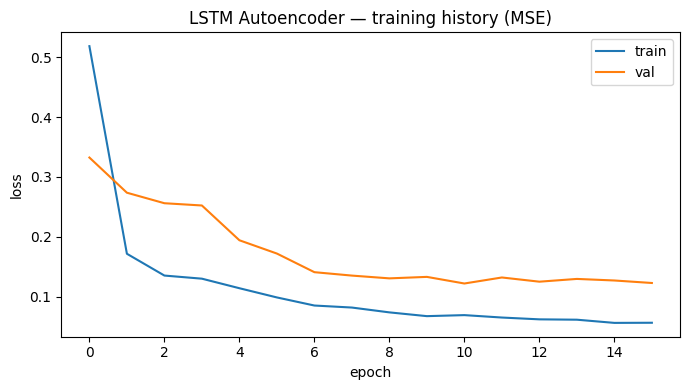

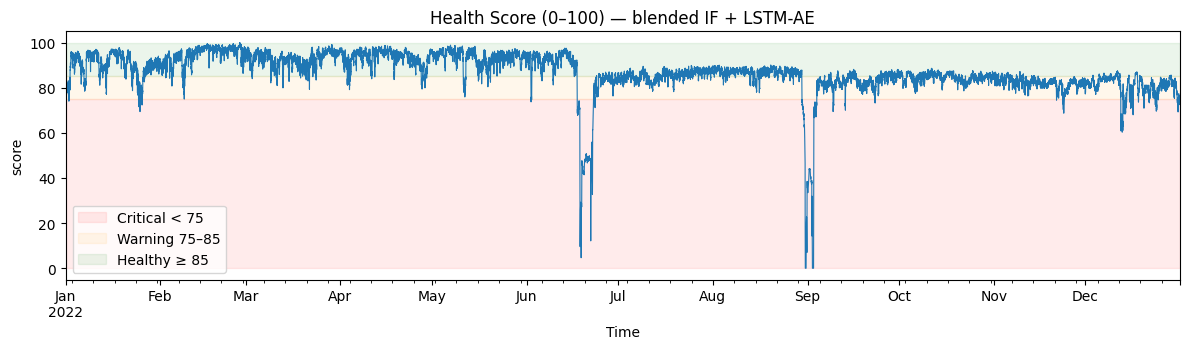

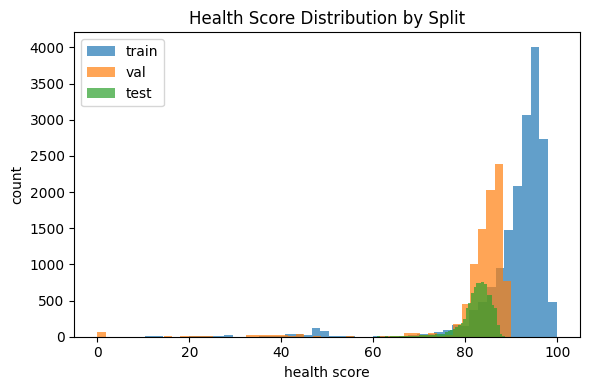

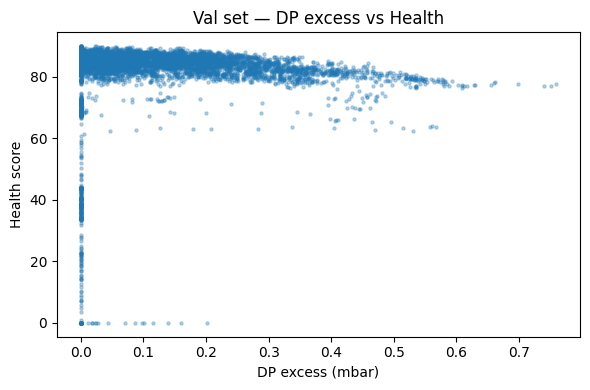

In [3]:
# ============================================================
# PHASE 3 — Unsupervised Anomaly Models + Health Score
# (Isolation Forest + LSTM Autoencoder) with saved artifacts
# ============================================================

import os, json, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import joblib
warnings.filterwarnings("ignore")

# ---- tf/keras (Kaggle has TF preinstalled) ----
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ARTIFACT_DIR = "./outputs/artifacts"
FIG_DIR = "./outputs/figures"
Path(ARTIFACT_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

# -----------------
# 0) Load inputs from Phase 2
# -----------------
with open(f"{ARTIFACT_DIR}/manifest.json", "r") as f:
    manifest = json.load(f)
CONFIG = manifest["config"]
EXPECTED_FREQ = CONFIG.get("EXPECTED_FREQ", "15min")
DP_LIMIT_MBAR = CONFIG.get("DP_LIMIT_MBAR", 50.0)
FIG_DPI = CONFIG.get("FIG_DPI", 300)
RANDOM_STATE = CONFIG.get("RANDOM_STATE", 42)

def _savefig(name: str):
    plt.tight_layout()
    path = f"{FIG_DIR}/{name}.png"
    plt.savefig(path, dpi=FIG_DPI, bbox_inches="tight")
    print(f"[FIG] Saved: {path}")

df_feat = pd.read_parquet(f"{ARTIFACT_DIR}/features_phase2.parquet")
dp_col = manifest["dp_column"]

# -----------------
# 1) Rebuild time splits
# -----------------
idx = df_feat.index
train_mask = (idx >= "2022-01-01") & (idx < "2022-07-01")
val_mask   = (idx >= "2022-07-01") & (idx < "2022-10-01")
test_mask  = (idx >= "2022-10-01") & (idx <= "2022-12-31 23:45:00")
print("[INFO] Split sizes:", train_mask.sum(), val_mask.sum(), test_mask.sum())

# -----------------
# 2) Select columns for models
# -----------------
all_cols = df_feat.columns.tolist()
num_cols = [c for c in all_cols if c != "regime" and pd.api.types.is_numeric_dtype(df_feat[c])]

# A compact DP-centric subset for the LSTM (to keep memory/time reasonable)
# Heuristic: choose DP + top-5 original sensors most correlated with DP
orig_sensor_cols = [c for c in num_cols if re.fullmatch(r"\d+\w+\.pv", str(c))]
corr = df_feat[orig_sensor_cols].corr()[dp_col].abs().sort_values(ascending=False)
top5 = [c for c in corr.index if c != dp_col][:5]
lstm_cols = [dp_col] + top5

print("[INFO] LSTM feature set:", lstm_cols)

# For Isolation Forest we can use a broader set: original sensors + a few engineered DP features
if "dp_excess_mbar" in df_feat.columns and "dp_auc_cum_mbar_h" in df_feat.columns and "dp_baseline_mbar" in df_feat.columns:
    if_cols = orig_sensor_cols + ["dp_excess_mbar", "dp_baseline_mbar", "dp_auc_cum_mbar_h"]
else:
    if_cols = orig_sensor_cols

# -----------------
# 3) Isolation Forest (train-only fit)
# -----------------
print("\n[IsolationForest] Training...")
X_train_if = df_feat.loc[train_mask, if_cols].copy()
X_val_if   = df_feat.loc[val_mask, if_cols].copy()
X_test_if  = df_feat.loc[test_mask, if_cols].copy()

# pipeline: impute -> scale -> IF
if_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("if", IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=0.03,  # small fraction expected anomalous
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0,
    ))
])

if_pipe.fit(X_train_if)
print("[IsolationForest] Done.")

# Raw anomaly scores: the more negative, the more anomalous
def if_score(pipe, X):
    s = -pipe.decision_function(X)  # invert so that higher = more anomalous
    return pd.Series(s, index=X.index)

if_train = if_score(if_pipe, X_train_if)
if_val   = if_score(if_pipe, X_val_if)
if_test  = if_score(if_pipe, X_test_if)

# Normalize scores using train-only min-max
mm_if = MinMaxScaler().fit(if_train.values.reshape(-1,1))
if_train_n = pd.Series(mm_if.transform(if_train.values.reshape(-1,1)).ravel(), index=if_train.index)
if_val_n   = pd.Series(mm_if.transform(if_val.values.reshape(-1,1)).ravel(),   index=if_val.index)
if_test_n  = pd.Series(mm_if.transform(if_test.values.reshape(-1,1)).ravel(),  index=if_test.index)

# -----------------
# 4) LSTM Autoencoder
# -----------------
print("\n[LSTM-AE] Building windows and training...")

# Window parameters (causal)
WIN = 64               # 64*15min = 16 hours
STEP = 1               # stride
DT_HOURS = manifest.get("dt_hours", 0.25)

def make_windows(df_in, cols, win, step=1):
    X = df_in[cols].values.astype("float32")
    n = len(df_in)
    xs = []
    idxs = []
    for start in range(0, n - win + 1, step):
        end = start + win
        xs.append(X[start:end])
        idxs.append(df_in.index[end-1])  # align to window end (causal)
    return np.stack(xs), np.array(idxs)

# Build train/val/test sequences (use only rows in each split to avoid leakage)
train_df_lstm = df_feat.loc[train_mask, lstm_cols].copy()
val_df_lstm   = df_feat.loc[val_mask,   lstm_cols].copy()
test_df_lstm  = df_feat.loc[test_mask,  lstm_cols].copy()

# Impute forward/back to avoid NaNs inside windows
train_df_lstm = train_df_lstm.ffill().bfill()
val_df_lstm   = val_df_lstm.ffill().bfill()
test_df_lstm  = test_df_lstm.ffill().bfill()

# Scale features with train-only scaler
scaler_lstm = StandardScaler()
scaler_lstm.fit(train_df_lstm.values)
train_s = pd.DataFrame(scaler_lstm.transform(train_df_lstm.values), index=train_df_lstm.index, columns=lstm_cols)
val_s   = pd.DataFrame(scaler_lstm.transform(val_df_lstm.values),   index=val_df_lstm.index,   columns=lstm_cols)
test_s  = pd.DataFrame(scaler_lstm.transform(test_df_lstm.values),  index=test_df_lstm.index,  columns=lstm_cols)

X_train_lstm, t_train = make_windows(train_s, lstm_cols, WIN, STEP)
X_val_lstm,   t_val   = make_windows(val_s,   lstm_cols, WIN, STEP)
X_test_lstm,  t_test  = make_windows(test_s,  lstm_cols, WIN, STEP)

print(f"[LSTM-AE] Windowed shapes — train: {X_train_lstm.shape}, val: {X_val_lstm.shape}, test: {X_test_lstm.shape}")

# Build model
tf.keras.utils.set_random_seed(RANDOM_STATE)
inp = layers.Input(shape=(WIN, len(lstm_cols)))
x = layers.LSTM(32, return_sequences=True)(inp)
x = layers.LSTM(16, return_sequences=False)(x)
encoded = layers.Dense(12, activation="relu")(x)
x = layers.RepeatVector(WIN)(encoded)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(32, return_sequences=True)(x)
out = layers.TimeDistributed(layers.Dense(len(lstm_cols)))(x)
model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rp = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

hist = model.fit(
    X_train_lstm, X_train_lstm,
    validation_data=(X_val_lstm, X_val_lstm),
    epochs=30,
    batch_size=128,
    callbacks=[es, rp],
    verbose=2
)

# Plot training history
plt.figure(figsize=(7,4))
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("LSTM Autoencoder — training history (MSE)")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
_savefig("08_lstm_ae_history")

# Reconstruction error to anomaly score
def recon_error(model, X, idx):
    X_hat = model.predict(X, verbose=0)
    err = np.mean((X - X_hat)**2, axis=(1,2))
    return pd.Series(err, index=pd.to_datetime(idx))

ae_train_err = recon_error(model, X_train_lstm, t_train)
ae_val_err   = recon_error(model, X_val_lstm,   t_val)
ae_test_err  = recon_error(model, X_test_lstm,  t_test)

# Normalize on train-only to [0,1]
mm_ae = MinMaxScaler().fit(ae_train_err.values.reshape(-1,1))
ae_train_n = pd.Series(mm_ae.transform(ae_train_err.values.reshape(-1,1)).ravel(), index=ae_train_err.index)
ae_val_n   = pd.Series(mm_ae.transform(ae_val_err.values.reshape(-1,1)).ravel(),   index=ae_val_err.index)
ae_test_n  = pd.Series(mm_ae.transform(ae_test_err.values.reshape(-1,1)).ravel(),  index=ae_test_err.index)

# Smooth to inference cadence (align scores to the original index)
def align_series_to_index(score_s, full_index):
    # score_s index is at window ends; reindex to full series with ffill
    s = score_s.reindex(full_index, method="ffill")
    return s

if_full = pd.concat([if_train_n, if_val_n, if_test_n]).sort_index()
ae_full = pd.concat([ae_train_n, ae_val_n, ae_test_n]).sort_index()

score_if = align_series_to_index(if_full, df_feat.index)
score_ae = align_series_to_index(ae_full, df_feat.index)

# Blend scores and compute Health Score
blended = 0.5*score_if + 0.5*score_ae
health_score = 100.0 * (1.0 - blended.clip(0,1))

# -----------------
# 5) Health bands and visual checks
# -----------------
HEALTH_BANDS = {"critical": 75.0, "warning": 85.0}  # <75 critical; 75–85 warning; >=85 healthy

plt.figure(figsize=(12,3.6))
health_score.plot(linewidth=0.8)
plt.axhspan(0, HEALTH_BANDS["critical"], color="red", alpha=0.08, label="Critical < 75")
plt.axhspan(HEALTH_BANDS["critical"], HEALTH_BANDS["warning"], color="orange", alpha=0.08, label="Warning 75–85")
plt.axhspan(HEALTH_BANDS["warning"], 100, color="green", alpha=0.08, label="Healthy ≥ 85")
plt.title("Health Score (0–100) — blended IF + LSTM-AE")
plt.ylabel("score"); plt.xlabel("Time"); plt.legend(loc="lower left")
_savefig("09_health_score_timeline")

plt.figure(figsize=(6,4))
plt.hist(health_score.loc[train_mask], bins=50, alpha=0.7, label="train")
plt.hist(health_score.loc[val_mask], bins=50, alpha=0.7, label="val")
plt.hist(health_score.loc[test_mask], bins=50, alpha=0.7, label="test")
plt.title("Health Score Distribution by Split")
plt.xlabel("health score"); plt.ylabel("count"); plt.legend()
_savefig("10_health_score_hist")

# Relationship with DP (sanity): higher DP_excess should push lower health
if "dp_excess_mbar" in df_feat.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df_feat.loc[val_mask, "dp_excess_mbar"], health_score.loc[val_mask], s=5, alpha=0.3)
    plt.title("Val set — DP excess vs Health")
    plt.xlabel("DP excess (mbar)"); plt.ylabel("Health score")
    _savefig("11_val_dp_excess_vs_health")

# -----------------
# 6) Persist artifacts for downstream phases
# -----------------
# Scores as a dataframe
scores_df = pd.DataFrame({
    "score_if": score_if,
    "score_ae": score_ae,
    "score_blended": blended,
    "health_score": health_score
})
scores_df.to_parquet(f"{ARTIFACT_DIR}/unsupervised_scores.parquet")
scores_df.loc[train_mask].to_parquet(f"{ARTIFACT_DIR}/unsup_scores_train.parquet")
scores_df.loc[val_mask].to_parquet(f"{ARTIFACT_DIR}/unsup_scores_val.parquet")
scores_df.loc[test_mask].to_parquet(f"{ARTIFACT_DIR}/unsup_scores_test.parquet")
print(f"[ARTIFACT] Saved anomaly/health scores → {ARTIFACT_DIR}/unsupervised_scores.parquet")

# Save models & scalers
joblib.dump(if_pipe, f"{ARTIFACT_DIR}/isoforest_pipeline.joblib")
joblib.dump(mm_if,   f"{ARTIFACT_DIR}/isoforest_minmax.joblib")
joblib.dump(scaler_lstm, f"{ARTIFACT_DIR}/lstm_scaler.joblib")
model.save(f"{ARTIFACT_DIR}/lstm_autoencoder.keras")
joblib.dump(mm_ae,   f"{ARTIFACT_DIR}/lstm_minmax.joblib")
print("[ARTIFACT] Saved IF pipeline, LSTM AE model, and scalers.")

# Update manifest with Phase 3 metadata
manifest["health_bands"] = HEALTH_BANDS
manifest["if_features"] = if_cols
manifest["lstm_cols"] = lstm_cols
manifest["lstm_window"] = WIN
with open(f"{ARTIFACT_DIR}/manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)
print("[ARTIFACT] Updated manifest with Phase 3 metadata.")

print("\n[PHASE 3 DONE] ✅  IF + LSTM-AE trained, blended, and saved. Figures:")
print(" - 08_lstm_ae_history.png")
print(" - 09_health_score_timeline.png")
print(" - 10_health_score_hist.png")
print(" - 11_val_dp_excess_vs_health.png (if dp_excess_mbar present)")

# Phase 4

[INFO] Split sizes: 17376 8832 8832
[WARN] 7d: picked closest limit 2.310 mbar (train rate=0.128)
[INFO] Features — degraded: 25 columns, 7d: 113 columns
[FIG] Saved: ./outputs/figures/15_degraded_cost_curve_val.png
[FIG] Saved: ./outputs/figures/12_degraded_test_pr.png
[FIG] Saved: ./outputs/figures/12_degraded_test_roc.png
[FIG] Saved: ./outputs/figures/12_degraded_test_cm.png

[degraded (test)] @thr=0.10 | P=0.795 R=0.992 F1=0.883  AP=0.915
[[  60 1785]
 [  58 6929]]
[FIG] Saved: ./outputs/figures/16_degraded_proba_hist.png
[FIG] Saved: ./outputs/figures/13_degraded_perm_importance.png
[degraded] FP/month≈582.1, FN/month≈18.9 @thr=0.10
[FIG] Saved: ./outputs/figures/15_breach7d_cost_curve_val.png
[FIG] Saved: ./outputs/figures/12_breach7d_test_pr.png
[FIG] Saved: ./outputs/figures/12_breach7d_test_roc.png
[FIG] Saved: ./outputs/figures/12_breach7d_test_cm.png

[breach7d (test)] @thr=0.05 | P=0.238 R=0.468 F1=0.316  AP=0.330
[[3977 2912]
 [1033  910]]
[FIG] Saved: ./outputs/figures/1

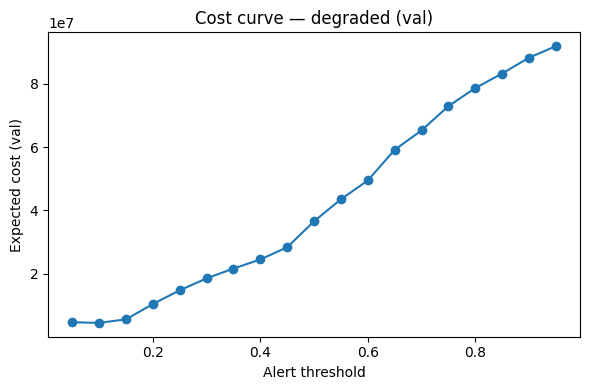

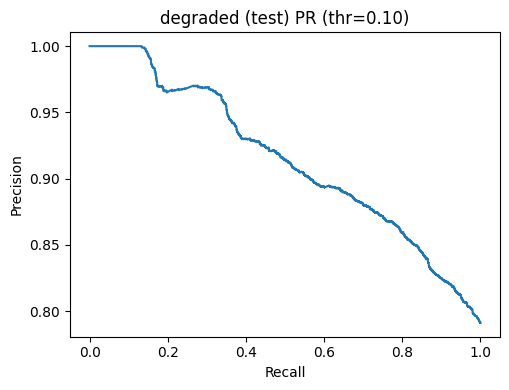

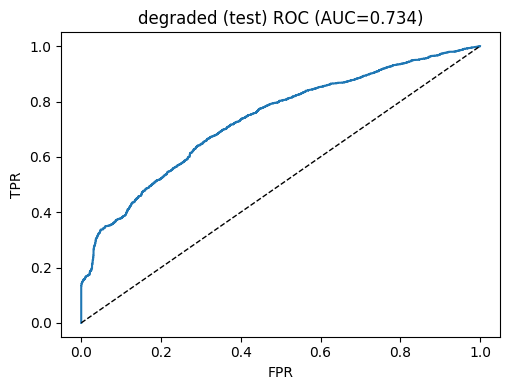

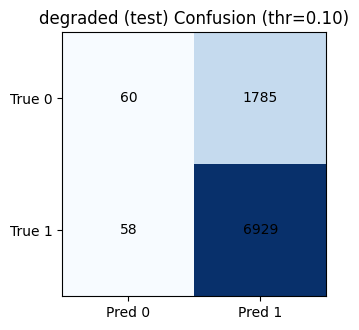

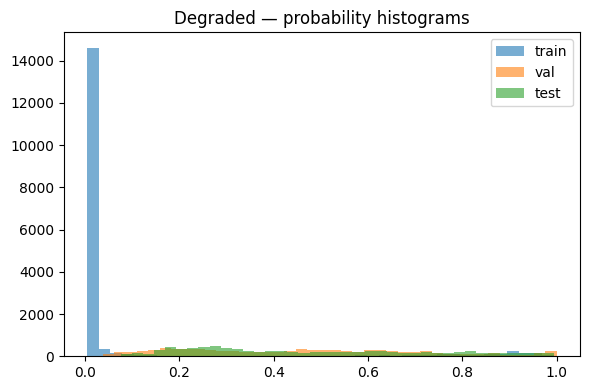

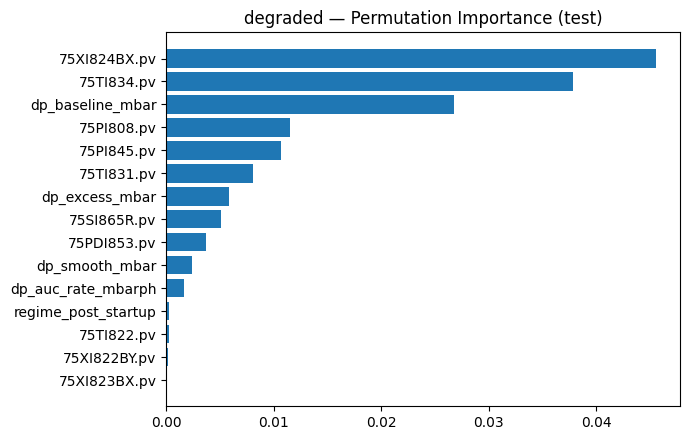

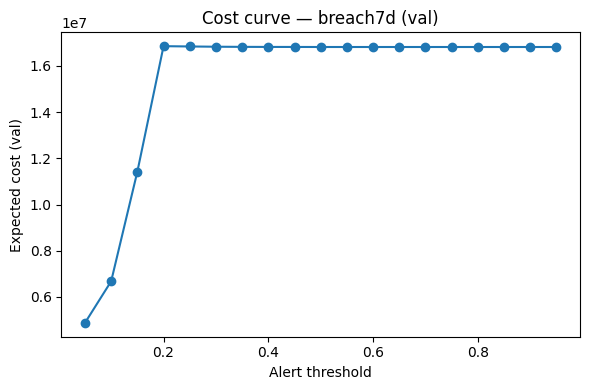

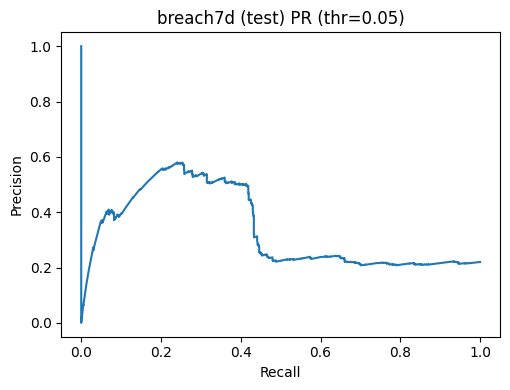

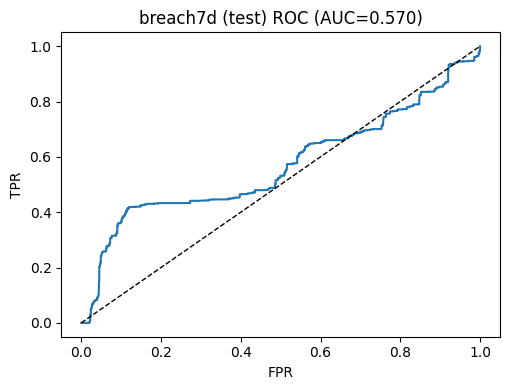

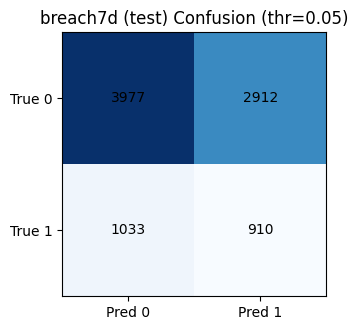

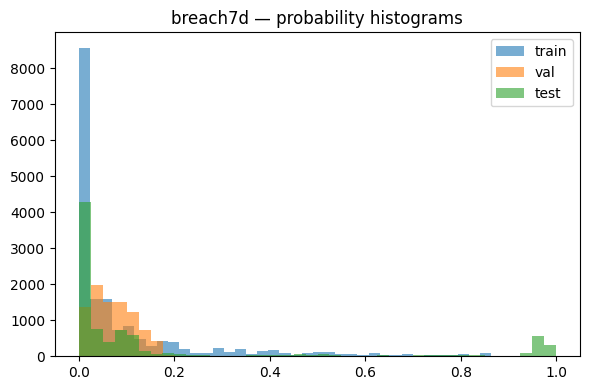

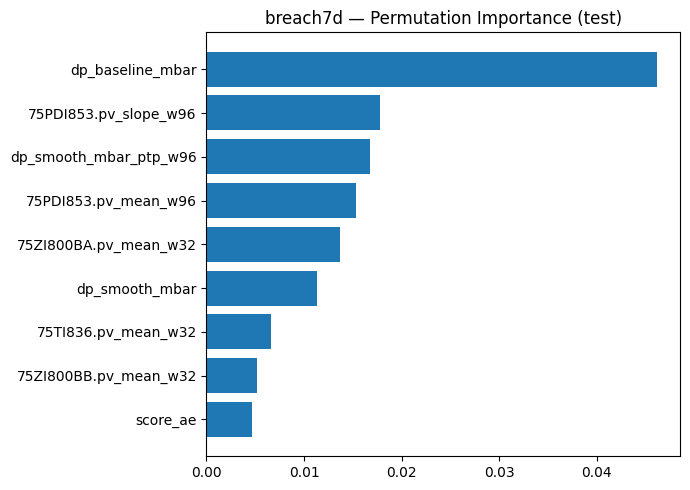

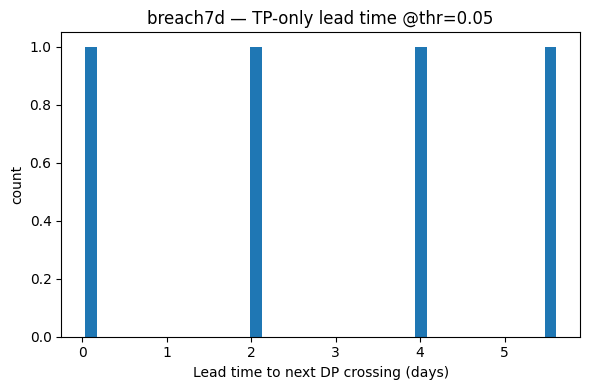

In [4]:
# ============================================================
# PHASE 4 — FINAL (Degraded + 7-day breach only)
# ------------------------------------------------------------
# - Keeps your strong "Degraded" classifier pipeline.
# - Retains improved labeling & features.
# - Removes 14d/30d. Only trains, tunes, and evaluates 7d.
# - Adds class-weighted training for 7d to combat imbalance.
# - Saves calibrated models, figures, CSVs, and manifest updates.
# - HOT-FIX: Median imputation added. Feature matrices hardened.
# ============================================================

import os, json, warnings, math, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    confusion_matrix, precision_recall_curve, roc_curve, auc, average_precision_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer  # PATCH: add imputer

import joblib
warnings.filterwarnings("ignore")

# -----------------------------
# I/O & Config
# -----------------------------
ARTIFACT_DIR = "./outputs/artifacts"
FIG_DIR = "./outputs/figures"
Path(ARTIFACT_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

def _savefig(name: str, dpi=300):
    path = f"{FIG_DIR}/{name}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[FIG] Saved: {path}")

with open(f"{ARTIFACT_DIR}/manifest.json","r") as f:
    manifest = json.load(f)

CONFIG = manifest["config"]
RANDOM_STATE = CONFIG.get("RANDOM_STATE", 42)
FREQ = pd.Timedelta(CONFIG.get("EXPECTED_FREQ","15min"))
DP_LIMIT_DEFAULT = float(CONFIG.get("DP_LIMIT_MBAR", 50.0))  # fallback only
HEALTH_BANDS  = manifest.get("health_bands", {"critical":75.0, "warning":85.0})

# --- Scope: only 7-day breach ---
HORIZON_DAYS = 7
TARGET_POS_RATE = (0.06, 0.12)  # train positive rate band
DP_SMOOTH_STEPS = int(pd.Timedelta("2H") / FREQ)   # 2-hour median for labels/features
EVENT_COOLDOWN_D = 7  # days
ALERT_PERSIST_K = 3   # require k consecutive points above thr
ALERT_COOLDOWN_H = 48 # cooldown in hours

# Load inputs
dp_col = manifest["dp_column"]
feat   = pd.read_parquet(f"{ARTIFACT_DIR}/features_phase2.parquet")
scores = pd.read_parquet(f"{ARTIFACT_DIR}/unsupervised_scores.parquet")
df0 = feat.join(scores, how="inner")

# Splits
idx = df0.index
train_mask = (idx >= "2022-01-01") & (idx < "2022-07-01")
val_mask   = (idx >= "2022-07-01") & (idx < "2022-10-01")
test_mask  = (idx >= "2022-10-01") & (idx <= "2022-12-31 23:45:00")
print("[INFO] Split sizes:", train_mask.sum(), val_mask.sum(), test_mask.sum())

# -----------------------------
# Helpers
# -----------------------------
def smooth_dp(series: pd.Series, steps: int) -> pd.Series:
    if steps <= 1: 
        return series
    return series.rolling(steps, min_periods=max(1, steps//2)).median()

def first_crossings(dp: pd.Series, limit: float) -> pd.Series:
    return (dp.shift(1) < limit) & (dp >= limit)

def make_event_window_labels(dp: pd.Series, limit: float, horizon_days: int,
                             cooldown_days: int) -> tuple[pd.Series, pd.DatetimeIndex]:
    events = first_crossings(dp, limit)
    event_times = dp.index[events]
    y = pd.Series(0, index=dp.index, dtype=int)
    horizon = pd.Timedelta(f"{horizon_days}D")
    cooldown = pd.Timedelta(f"{cooldown_days}D")
    for t in event_times:
        start = t - horizon
        y.loc[(dp.index >= start) & (dp.index < t)] = 1
        y.loc[(dp.index >= t) & (dp.index < t + cooldown)] = 0
    y.loc[dp >= limit] = 0
    return y.rename(f"breach{horizon_days}d"), event_times

def autotune_limit(dp_smooth: pd.Series, train_mask, horizon_days: int,
                   target_rate: tuple[float,float],
                   guard: tuple[float,float]=(1.5, 8.0)) -> float:
    train_dp = dp_smooth.loc[train_mask]
    search_pcts = [99.9, 99.5, 99.0, 98.0, 97.0, 96.0, 95.0, 94.0, 93.0, 92.0, 91.0, 90.0, 88.0, 85.0]
    candidates = []
    for p in search_pcts:
        lim = float(np.nanpercentile(train_dp.values, p))
        lim = float(np.clip(lim, guard[0], guard[1]))
        candidates.append(lim)
    if guard[0] <= DP_LIMIT_DEFAULT <= guard[1]:
        candidates.append(float(DP_LIMIT_DEFAULT))

    chosen, chosen_rate = None, None
    rates = []
    for lim in candidates:
        y_tmp, _ = make_event_window_labels(dp_smooth, lim, horizon_days, EVENT_COOLDOWN_D)
        rate = float(y_tmp.loc[train_mask].mean())
        rates.append(rate)
        if target_rate[0] <= rate <= target_rate[1]:
            chosen, chosen_rate = lim, rate
            break

    if chosen is None:
        tgt_mid = 0.5*(target_rate[0]+target_rate[1])
        best_i = int(np.argmin([abs(r - tgt_mid) for r in rates]))
        chosen, chosen_rate = candidates[best_i], rates[best_i]
        print(f"[WARN] {horizon_days}d: picked closest limit {chosen:.3f} mbar (train rate={chosen_rate:.3f})")
    else:
        print(f"[AUTO] {horizon_days}d: limit={chosen:.3f} mbar (train rate={chosen_rate:.3f})")
    return chosen

# PATCH: add SimpleImputer to both calibrated pipelines
def fit_calibrated_clf(X_train, y_train, X_cal, y_cal, sample_weight=None, seed=42):
    base = GradientBoostingClassifier(
        random_state=seed, max_depth=3, n_estimators=600, learning_rate=0.03, subsample=0.9
    )
    pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("gb", base),
    ])
    pipe.fit(X_train, y_train, gb__sample_weight=sample_weight)

    gb2 = GradientBoostingClassifier(
        random_state=seed, max_depth=3, n_estimators=600, learning_rate=0.03, subsample=0.9
    )
    pipe2 = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("gb", gb2),
    ])
    pipe2.fit(X_train, y_train, gb__sample_weight=sample_weight)

    calib = CalibratedClassifierCV(pipe2, method="sigmoid", cv="prefit")
    calib.fit(X_cal, y_cal)
    return pipe, calib

def best_threshold_by_cost(y_true_val, proba_val, cost_fp=1000.0, cost_fn=25000.0):
    ths = np.linspace(0.05, 0.95, 19)
    costs = []
    for thr in ths:
        y_pred = (proba_val >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true_val, y_pred, labels=[0,1]).ravel()
        costs.append(fp*cost_fp + fn*cost_fn)
    best_i = int(np.argmin(costs))
    return float(ths[best_i]), ths, costs

def pr_roc_cm(name, y_true, proba, thr, prefix):
    y_pred = (proba >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0.0
    ap   = average_precision_score(y_true, proba)
    has_both = (np.unique(y_true).size == 2)

    # PR
    p, r, _ = precision_recall_curve(y_true, proba)
    plt.figure(figsize=(5.2,4))
    plt.plot(r, p)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{name} PR (thr={thr:.2f})")
    _savefig(f"{prefix}_pr")

    # ROC
    if has_both:
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5.2,4))
        plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'k--',lw=1)
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{name} ROC (AUC={roc_auc:.3f})")
        _savefig(f"{prefix}_roc")
    else:
        roc_auc = float("nan")
        plt.figure(figsize=(5.2,4))
        plt.text(0.5,0.5,"ROC unavailable (single-class y)", ha="center", va="center")
        plt.axis("off"); _savefig(f"{prefix}_roc")

    # Confusion
    plt.figure(figsize=(3.6,3.4))
    plt.imshow(cm, cmap="Blues")
    plt.xticks([0,1],["Pred 0","Pred 1"]); plt.yticks([0,1],["True 0","True 1"])
    for (i,j),v in np.ndenumerate(cm):
        plt.text(j,i,str(v),ha="center",va="center")
    plt.title(f"{name} Confusion (thr={thr:.2f})")
    _savefig(f"{prefix}_cm")

    print(f"\n[{name}] @thr={thr:.2f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}  AP={ap:.3f}")
    print(cm)
    return cm

def fp_fn_per_30_days(cm, n_points, freq: pd.Timedelta):
    _, fp, fn, _ = cm.ravel()
    days = n_points * (freq / pd.Timedelta("1D"))
    factor = 30.0 / float(days) if days > 0 else np.nan
    return float(fp*factor), float(fn*factor)

def derive_operational_alerts(prob_s: pd.Series, thr: float, persist_k:int, cooldown_h:int) -> pd.DatetimeIndex:
    above = (prob_s >= thr).astype(int)
    alerts = []
    i = 0
    times = prob_s.index
    while i < len(above):
        if above.iloc[i] == 1:
            j = i
            while j < len(above) and above.iloc[j] == 1: j += 1
            length = j - i
            if length >= persist_k:
                alerts.append(times[i + persist_k - 1])
                cool_until = alerts[-1] + pd.Timedelta(hours=cooldown_h)
                while j < len(times) and times[j] < cool_until: j += 1
            i = j
        else:
            i += 1
    return pd.DatetimeIndex(alerts)

def tp_only_lead_time(alert_times: pd.DatetimeIndex,
                      event_times: pd.DatetimeIndex,
                      y_true_series: pd.Series) -> np.ndarray:
    tp_idx = y_true_series.index[(y_true_series==1)]
    alerts_tp = alert_times.intersection(tp_idx)
    leads = []
    event_times = event_times.sort_values()
    for t in alerts_tp:
        nxt = event_times[event_times >= t]
        if len(nxt) > 0:
            leads.append(float((nxt[0] - t) / pd.Timedelta("1D")))
    return np.array(leads)

# ------------------------------------------------------------
# Aligned features & labels (7d only)
# ------------------------------------------------------------
df = df0.copy()

# Smoothed DP (2h) for both labeling & features
df["dp_smooth_mbar"] = smooth_dp(df[dp_col], DP_SMOOTH_STEPS)

# AUC rate (mbar/h per step -> divide by Δt)
dt_hours = float(manifest.get("dt_hours", 0.25))
if "dp_auc_cum_mbar_h" in df.columns:
    df["dp_auc_rate_mbarph"] = df["dp_auc_cum_mbar_h"].diff().fillna(0) / max(dt_hours, 1e-6)

# Feature windows (from Phase-2)
W_SHORT = manifest["feature_windows"]["short"]   # ~2h
W_MED   = manifest["feature_windows"]["med"]     # ~8h
W_LONG  = manifest["feature_windows"]["long"]    # ~24h

def add_rollset(frame: pd.DataFrame, col: str, w: int):
    rr = {}
    s = frame[col]
    rr[f"{col}_mean_w{w}"] = s.rolling(w, min_periods=max(2,w//2)).mean()
    rr[f"{col}_std_w{w}"]  = s.rolling(w, min_periods=max(2,w//2)).std()
    rr[f"{col}_min_w{w}"]  = s.rolling(w, min_periods=max(2,w//2)).min()
    rr[f"{col}_max_w{w}"]  = s.rolling(w, min_periods=max(2,w//2)).max()
    rr[f"{col}_ptp_w{w}"]  = rr[f"{col}_max_w{w}"] - rr[f"{col}_min_w{w}"]
    rr[f"{col}_slope_w{w}"]= (s - s.shift(w)) / (w * dt_hours)
    return pd.DataFrame(rr, index=frame.index)

# Top drivers (3) by |corr| with DP
orig_cols = [c for c in df.columns if re.fullmatch(r"\d+\w+\.pv", str(c))]
corr = df[orig_cols].corr()[dp_col].abs().sort_values(ascending=False)
top_drivers = [c for c in corr.index if c != dp_col][:3]

# Rolling features for DP/DP_smooth + top drivers
eng_parts = []
for c in [dp_col, "dp_smooth_mbar"] + top_drivers:
    for w in [W_SHORT, W_MED, W_LONG if c in [dp_col, "dp_smooth_mbar"] else W_MED]:
        eng_parts.append(add_rollset(df, c, w))
df_eng = pd.concat(eng_parts, axis=1)

# 7-day labels & limit (auto-tuned on train)
limit_7d = autotune_limit(df["dp_smooth_mbar"], train_mask, HORIZON_DAYS, TARGET_POS_RATE)
y_7d, events_7d = make_event_window_labels(df["dp_smooth_mbar"], limit_7d, HORIZON_DAYS, EVENT_COOLDOWN_D)

# Degraded label (unchanged)
warning_thr = float(HEALTH_BANDS["warning"])
y_deg = (df["health_score"] < warning_thr).astype(int).rename("degraded")

# ------------------------------------------------------------
# Feature matrices
# ------------------------------------------------------------
# Base originals + auxiliaries
base_cols  = [c for c in df.columns if c.endswith(".pv")]
aux_cols   = [x for x in ["dp_excess_mbar","dp_auc_cum_mbar_h","dp_baseline_mbar","dp_auc_rate_mbarph","dp_smooth_mbar"] if x in df.columns]
score_cols = ["score_if","score_ae","score_blended","health_score"]

# Regime one-hot
df_reg = pd.get_dummies(df["regime"], prefix="regime", drop_first=False)

# Degraded — keep score-free, plus regimes
keep_deg = list(dict.fromkeys(
    [dp_col] + aux_cols +
    [c for c in base_cols if c.startswith("75TI")][:6] +
    [c for c in base_cols if c.startswith("75PI")][:4] +
    [c for c in base_cols if c.startswith("75XI")][:4] +
    [c for c in base_cols if "SI865R" in c][:1]
))
X_deg = pd.concat([df[keep_deg], df_reg], axis=1)

# 7d breach — include scores + engineered trend set + regimes
eng_keep = [c for c in df_eng.columns if any(
    pat in c for pat in [
        f"{dp_col}_mean_w", f"{dp_col}_std_w", f"{dp_col}_ptp_w", f"{dp_col}_slope_w",
        "dp_smooth_mbar_mean_w", "dp_smooth_mbar_std_w", "dp_smooth_mbar_ptp_w", "dp_smooth_mbar_slope_w"
    ])
] + [c for c in df_eng.columns if any(td in c for td in top_drivers) and any(
        pat in c for pat in ["_std_w","_ptp_w","_slope_w","_mean_w"]
    )]

keep_7d = list(dict.fromkeys(
    [dp_col] + aux_cols + score_cols +
    [c for c in base_cols if c.startswith("75TI")][:6] +
    [c for c in base_cols if c.startswith("75PI")][:4] +
    [c for c in base_cols if c.startswith("75XI")][:4] +
    [c for c in base_cols if "SI865R" in c][:1]
))
X7_base = df[keep_7d]
X_7d = pd.concat([X7_base, df_eng[eng_keep], df_reg], axis=1)

# PATCH: harden matrices to remove NaNs before modeling
X_deg = X_deg.copy().ffill().bfill()
assert not X_deg.isna().any().any(), "X_deg still has NaNs after ffill/bfill."

X_7d = X_7d.copy().ffill().bfill()
assert not X_7d.isna().any().any(), "X_7d still has NaNs after ffill/bfill."

print(f"[INFO] Features — degraded: {X_deg.shape[1]} columns, 7d: {X_7d.shape[1]} columns")
pd.Series(X_deg.columns).to_csv(f"{ARTIFACT_DIR}/feature_list_degraded.csv", index=False)
pd.Series(X_7d.columns).to_csv(f"{ARTIFACT_DIR}/feature_list_breach7d.csv", index=False)

# ------------------------------------------------------------
# TRAIN / EVAL — Degraded (as before, now with imputer)
# ------------------------------------------------------------
COST_FP, COST_FN = 1_000.0, 25_000.0
Xtr, Xva, Xte = X_deg.loc[train_mask], X_deg.loc[val_mask], X_deg.loc[test_mask]
ytr, yva, yte = y_deg.loc[train_mask], y_deg.loc[val_mask], y_deg.loc[test_mask]

pipe_deg, calib_deg = fit_calibrated_clf(Xtr, ytr, Xva, yva, seed=RANDOM_STATE)
proba_val = calib_deg.predict_proba(Xva)[:,1]
thr_deg, ths, costs = best_threshold_by_cost(yva.values, proba_val, COST_FP, COST_FN)

plt.figure(figsize=(6,4)); plt.plot(ths, costs, marker="o")
plt.xlabel("Alert threshold"); plt.ylabel("Expected cost (val)"); plt.title("Cost curve — degraded (val)")
_savefig("15_degraded_cost_curve_val")

proba_te = calib_deg.predict_proba(Xte)[:,1]
cm_deg = pr_roc_cm("degraded (test)", yte.values, proba_te, thr_deg, "12_degraded_test")

# Prob hist (QA)
plt.figure(figsize=(6,4))
plt.hist(calib_deg.predict_proba(Xtr)[:,1], bins=40, alpha=0.6, label="train")
plt.hist(proba_val, bins=40, alpha=0.6, label="val")
plt.hist(proba_te, bins=40, alpha=0.6, label="test")
plt.legend(); plt.title("Degraded — probability histograms")
_savefig("16_degraded_proba_hist")

r = permutation_importance(pipe_deg, Xte, yte, n_repeats=10, random_state=RANDOM_STATE, scoring="average_precision")
imp = pd.Series(r.importances_mean, index=Xte.columns).sort_values(ascending=False).head(15)[::-1]
plt.figure(figsize=(7,4.5)); plt.barh(imp.index, imp.values); plt.title("degraded — Permutation Importance (test)")
_savefig("13_degraded_perm_importance")

fp_m, fn_m = fp_fn_per_30_days(cm_deg, len(Xte), FREQ)
print(f"[degraded] FP/month≈{fp_m:.1f}, FN/month≈{fn_m:.1f} @thr={thr_deg:.2f}")

joblib.dump(calib_deg, f"{ARTIFACT_DIR}/clf_calibrated_degraded.joblib")

# ------------------------------------------------------------
# TRAIN / EVAL — 7-day breach (class-weighted + imputer)
# ------------------------------------------------------------
Xtr, Xva, Xte = X_7d.loc[train_mask], X_7d.loc[val_mask], X_7d.loc[test_mask]
ytr, yva, yte = y_7d.loc[train_mask], y_7d.loc[val_mask], y_7d.loc[test_mask]

# sample weights to counter class imbalance (positive gets higher weight)
pos = float((ytr==1).sum()); neg = float((ytr==0).sum())
w_pos = (neg/pos) if pos > 0 else 1.0
w_tr = np.where(ytr.values==1, w_pos, 1.0)

pipe_7d, calib_7d = fit_calibrated_clf(Xtr, ytr, Xva, yva, sample_weight=w_tr, seed=RANDOM_STATE)

proba_va_7d = calib_7d.predict_proba(Xva)[:,1]
thr_7d, ths, costs = best_threshold_by_cost(yva.values, proba_va_7d, COST_FP, COST_FN)
plt.figure(figsize=(6,4)); plt.plot(ths, costs, marker="o")
plt.xlabel("Alert threshold"); plt.ylabel("Expected cost (val)")
plt.title("Cost curve — breach7d (val)")
_savefig("15_breach7d_cost_curve_val")

proba_te_7d = calib_7d.predict_proba(Xte)[:,1]
cm_7d = pr_roc_cm("breach7d (test)", yte.values, proba_te_7d, thr_7d, "12_breach7d_test")

# Probability hist (QA)
plt.figure(figsize=(6,4))
plt.hist(calib_7d.predict_proba(Xtr)[:,1], bins=40, alpha=0.6, label="train")
plt.hist(proba_va_7d, bins=40, alpha=0.6, label="val")
plt.hist(proba_te_7d, bins=40, alpha=0.6, label="test")
plt.legend(); plt.title("breach7d — probability histograms")
_savefig("16_breach7d_proba_hist")

# Permutation importance (test)
r = permutation_importance(pipe_7d, Xte, yte, n_repeats=10, random_state=RANDOM_STATE, scoring="average_precision")
imp7 = pd.Series(r.importances_mean, index=Xte.columns).sort_values(ascending=False).head(18)[::-1]
plt.figure(figsize=(7,5)); plt.barh(imp7.index, imp7.values); plt.title("breach7d — Permutation Importance (test)")
_savefig("13_breach7d_perm_importance")

# Operational alerts with persistence & cooldown (test window)
proba_s_test = pd.Series(proba_te_7d, index=Xte.index)
alerts_7d = derive_operational_alerts(proba_s_test, thr_7d, ALERT_PERSIST_K, ALERT_COOLDOWN_H)

# TP-only lead time stats
leads_tp = tp_only_lead_time(alerts_7d, events_7d, y_7d.loc[test_mask])
if len(leads_tp) > 0:
    plt.figure(figsize=(6,4)); plt.hist(leads_tp, bins=40)
    plt.xlabel("Lead time to next DP crossing (days)"); plt.ylabel("count")
    plt.title(f"breach7d — TP-only lead time @thr={thr_7d:.2f}")
    _savefig("14_breach7d_leadtime")
    print(f"[breach7d] TP-only median lead time: {np.median(leads_tp):.2f} days (n={len(leads_tp)})")

# Coverage & per-30-day KPIs
cov = None
if len(events_7d) > 0:
    cov = np.nan
    test_idx = Xte.index
    window = pd.Timedelta(f"{HORIZON_DAYS}D")
    ev_test = events_7d[(events_7d >= test_idx.min()) & (events_7d <= test_idx.max())]
    if len(ev_test) > 0:
        covered = []
        for e in ev_test:
            covered.append((alerts_7d[(alerts_7d >= e-window) & (alerts_7d < e)].size > 0))
        cov = 100.0 * float(np.mean(covered))
    print(f"[breach7d] Event coverage: {cov if cov==cov else float('nan'):.1f}%")

fp_m, fn_m = fp_fn_per_30_days(cm_7d, len(Xte), FREQ)
print(f"[breach7d] FP/month≈{fp_m:.1f}, FN/month≈{fn_m:.1f} @thr={thr_7d:.2f}")

# Save model + update manifest
joblib.dump(calib_7d, f"{ARTIFACT_DIR}/clf_calibrated_breach7d.joblib")

manifest["limits_mbar"] = {"7d": float(limit_7d)}
manifest["best_thresholds"] = {"degraded": float(thr_deg), "breach7d": float(thr_7d)}
manifest["labeling_params"] = {
    "dp_smooth_hours": float(pd.Timedelta(DP_SMOOTH_STEPS * FREQ) / pd.Timedelta("1H")),
    "event_cooldown_days": EVENT_COOLDOWN_D
}
manifest["alerting_params"] = {"persist_k": ALERT_PERSIST_K, "cooldown_hours": ALERT_COOLDOWN_H}
with open(f"{ARTIFACT_DIR}/manifest.json","w") as f:
    json.dump(manifest, f, indent=2)

print("\n[PHASE 4 — FINAL DONE] ✅ Degraded + 7d breach models trained and saved.")
print("Figures: 12_degraded_*, 13_degraded_*, 15_degraded_cost_curve_val.png, 16_degraded_proba_hist.png;")
print("         12_breach7d_*, 13_breach7d_*, 14_breach7d_leadtime.png, 15_breach7d_cost_curve_val.png, 16_breach7d_proba_hist.png")
print("CSVs: feature_list_degraded.csv, feature_list_breach7d.csv")

[INFO] Final 7d feature matrix: X_all shape = (35040, 113)  (kept 113, skipped 0)
[KPI] Saved: ./outputs/kpis_breach7d.csv (shape=(35040, 10))
[KPI] Saved summary → ./outputs/kpis_summary.json
[FIG] Saved: ./outputs/figures/17_breach7d_prob_timeline_last60d.png
[FIG] Saved: ./outputs/figures/18_kpi_tiles.png

[PHASE 5 DONE] ✅ Dashboard KPIs & figures created.
Files:
 - ./outputs/kpis_breach7d.csv
 - ./outputs/kpis_summary.json
 - ./outputs/figures/17_breach7d_prob_timeline_last60d.png
 - ./outputs/figures/18_kpi_tiles.png


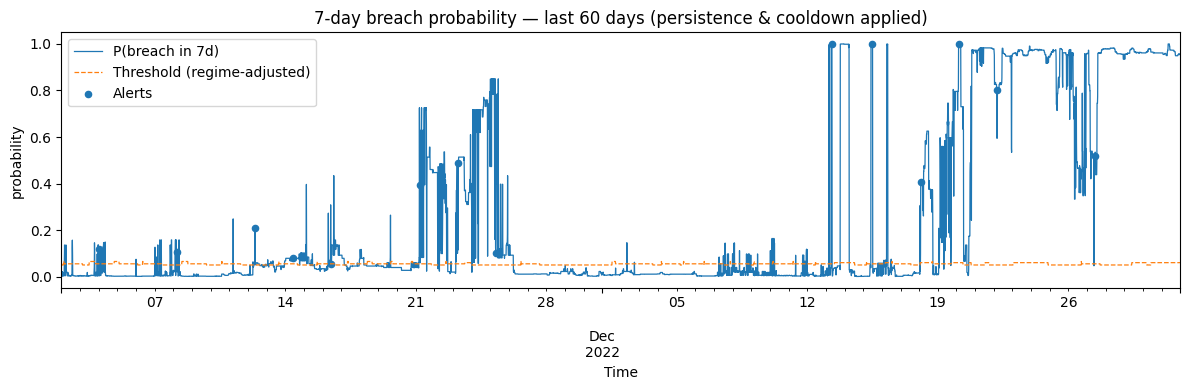

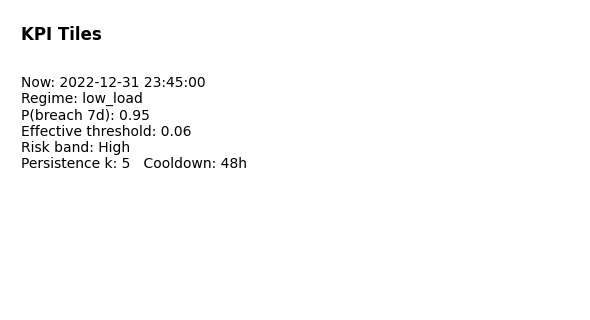

In [5]:
# ============================================================
# PHASE 5 — FIXED: Dashboard KPIs & Alert Timeline Export (7d)
#   - Rebuilds Phase-4 engineered features & regime dummies
#   - Loads and intersects feature list to avoid KeyErrors
# ============================================================

import os, json, re, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

warnings.filterwarnings("ignore")

ARTIFACT_DIR = "./outputs/artifacts"
FIG_DIR = "./outputs/figures"
OUT_DIR = "./outputs"
Path(ARTIFACT_DIR).mkdir(parents=True, exist_ok=True)
Path(FIG_DIR).mkdir(parents=True, exist_ok=True)

def _savefig(name: str, dpi=300):
    path = f"{FIG_DIR}/{name}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[FIG] Saved: {path}")

# -------- Load manifest, data, model
with open(f"{ARTIFACT_DIR}/manifest.json","r") as f:
    manifest = json.load(f)

CONFIG = manifest["config"]
FREQ = pd.Timedelta(CONFIG.get("EXPECTED_FREQ","15min"))
dp_col = manifest["dp_column"]
dt_hours = float(manifest.get("dt_hours", 0.25))
best_thr = float(manifest.get("best_thresholds",{}).get("breach7d", 0.10))

# Presentation-layer alert settings
PERSIST_K = int(manifest.get("alerting_params",{}).get("persist_k", 3))
COOLDOWN_H = int(manifest.get("alerting_params",{}).get("cooldown_hours", 48))
# tighten persistence as discussed (can change back if you want)
PERSIST_K = max(PERSIST_K, 5)

REGIME_THR_MULT = {"normal":1.00, "post_startup":1.10, "low_load":1.20, "shutdown":1.30}

# Base features & scores
feat = pd.read_parquet(f"{ARTIFACT_DIR}/features_phase2.parquet")
scores = pd.read_parquet(f"{ARTIFACT_DIR}/unsupervised_scores.parquet")
df = feat.join(scores, how="inner").copy()

# ---------- Rebuild engineered columns (same logic as Phase 4)
def smooth_dp(series, steps):
    return series.rolling(steps, min_periods=max(1, steps//2)).median()

DP_SMOOTH_STEPS = int(pd.Timedelta("2H") / FREQ)
df["dp_smooth_mbar"] = smooth_dp(df[dp_col], DP_SMOOTH_STEPS)
df["dp_auc_rate_mbarph"] = df["dp_auc_cum_mbar_h"].diff().fillna(0) / max(dt_hours, 1e-6)

W_SHORT = manifest["feature_windows"]["short"]   # 8
W_MED   = manifest["feature_windows"]["med"]     # 32
W_LONG  = manifest["feature_windows"]["long"]    # 96

def add_rollset(frame: pd.DataFrame, col: str, w: int):
    s = frame[col]
    out = {
        f"{col}_mean_w{w}" : s.rolling(w, min_periods=max(2,w//2)).mean(),
        f"{col}_std_w{w}"  : s.rolling(w, min_periods=max(2,w//2)).std(),
        f"{col}_min_w{w}"  : s.rolling(w, min_periods=max(2,w//2)).min(),
        f"{col}_max_w{w}"  : s.rolling(w, min_periods=max(2,w//2)).max(),
    }
    out[f"{col}_ptp_w{w}"]   = out[f"{col}_max_w{w}"] - out[f"{col}_min_w{w}"]
    out[f"{col}_slope_w{w}"] = (s - s.shift(w)) / (w * dt_hours)
    return pd.DataFrame(out, index=frame.index)

# Determine top 3 original drivers by |corr| with DP (as in Phase 4)
orig_cols = [c for c in df.columns if re.fullmatch(r"\d+\w+\.pv", str(c))]
corr = df[orig_cols].corr()[dp_col].abs().sort_values(ascending=False)
top_drivers = [c for c in corr.index if c != dp_col][:3]

# Build the engineered feature frame
eng_parts = []
for c in [dp_col, "dp_smooth_mbar"] + top_drivers:
    ws = [W_SHORT, W_MED] + ([W_LONG] if c in [dp_col, "dp_smooth_mbar"] else [])
    for w in ws:
        eng_parts.append(add_rollset(df, c, w))
df_eng = pd.concat(eng_parts, axis=1)

# Regime one-hots
df_reg = pd.get_dummies(df["regime"], prefix="regime", drop_first=False)

# ---------- Load saved feature list and intersect safely
flist_path = f"{ARTIFACT_DIR}/feature_list_breach7d.csv"
if not os.path.exists(flist_path):
    raise FileNotFoundError("feature_list_breach7d.csv not found (run Phase 4 first).")

feat_list = pd.read_csv(flist_path, header=None)[0].astype(str).tolist()
# Drop stray header value '0' if present
if len(feat_list) and feat_list[0] == "0":
    feat_list = feat_list[1:]

# Assemble the full candidate feature frame consistent with Phase 4
base_cols = [c for c in df.columns if c.endswith(".pv")]
aux_cols  = [x for x in ["dp_excess_mbar","dp_auc_cum_mbar_h","dp_baseline_mbar","dp_auc_rate_mbarph","dp_smooth_mbar"] if x in df.columns]
score_cols= ["score_if","score_ae","score_blended","health_score"]

X_base = df[[c for c in set([dp_col] + base_cols + aux_cols + score_cols) if c in df.columns]].ffill().bfill()
X_full = pd.concat([X_base, df_eng, df_reg], axis=1)

# Final feature matrix: keep the order from the saved list, intersect with available columns
keep = [c for c in feat_list if c in X_full.columns]
missing = [c for c in feat_list if c not in X_full.columns]
if missing:
    print(f"[WARN] {len(missing)} columns listed in feature_list_breach7d.csv were not found and will be skipped.")
X_all = X_full[keep].copy()
X_all = X_all.ffill().bfill()
print(f"[INFO] Final 7d feature matrix: X_all shape = {X_all.shape}  (kept {len(keep)}, skipped {len(missing)})")

# ---------- Inference with calibrated 7d model
calib_7d = joblib.load(f"{ARTIFACT_DIR}/clf_calibrated_breach7d.joblib")
proba_all = pd.Series(calib_7d.predict_proba(X_all)[:,1], index=X_all.index, name="prob_breach7d")

# Regime-aware threshold series
mult = df["regime"].map({"normal":1.00, "post_startup":1.10, "low_load":1.20, "shutdown":1.30}).astype(float).fillna(1.0)
thr_eff = (best_thr * mult).rename("threshold_eff")

# Persistence & cooldown alert derivation
def derive_alerts(prob_s, thr_s, persist_k, cooldown_h):
    assert (prob_s.index == thr_s.index).all()
    above = (prob_s >= thr_s).astype(int)
    alerts = np.zeros(len(above), dtype=int)
    i = 0; times = prob_s.index
    while i < len(above):
        if above.iloc[i]:
            j = i
            while j < len(above) and above.iloc[j]: j += 1
            length = j - i
            if length >= persist_k:
                fire_idx = i + persist_k - 1
                alerts[fire_idx] = 1
                cool_until = times[fire_idx] + pd.Timedelta(hours=cooldown_h)
                while j < len(times) and times[j] < cool_until: j += 1
            i = j
        else:
            i += 1
    return pd.Series(alerts, index=prob_s.index, name="alert_flag")

alert_flag = derive_alerts(proba_all, thr_eff, PERSIST_K, COOLDOWN_H)

# ---------- KPI table & exports
kpi_cols = [
    dp_col, "dp_smooth_mbar", "dp_excess_mbar", "dp_auc_cum_mbar_h",
    "health_score", "score_blended", "regime"
]
kpis = pd.concat([df[kpi_cols], proba_all, thr_eff, alert_flag], axis=1)

kpi_path = f"{OUT_DIR}/kpis_breach7d.csv"
kpis.to_csv(kpi_path)
print(f"[KPI] Saved: {kpi_path} (shape={kpis.shape})")

# Summary “tile”
last = kpis.iloc[-1]
risk_band = ("High" if last.prob_breach7d >= last.threshold_eff
             else "Medium" if last.prob_breach7d >= 0.5*best_thr
             else "Low")
summary = {
    "now": str(kpis.index[-1]),
    "regime": str(last["regime"]),
    "prob_breach7d": float(last.prob_breach7d),
    "threshold_eff": float(last.threshold_eff),
    "risk_band": risk_band,
    "persistence_k": int(PERSIST_K),
    "cooldown_hours": int(COOLDOWN_H),
    "base_threshold": float(best_thr),
    "regime_threshold_multipliers": REGIME_THR_MULT,
}
with open(f"{OUT_DIR}/kpis_summary.json","w") as f:
    json.dump(summary, f, indent=2)
print("[KPI] Saved summary → ./outputs/kpis_summary.json")

# ---------- Figures
lookback = pd.Timedelta("60D")
tail_idx = proba_all.index[proba_all.index >= (proba_all.index.max() - lookback)]

plt.figure(figsize=(12,4))
proba_all.loc[tail_idx].plot(linewidth=0.9, label="P(breach in 7d)")
thr_eff.loc[tail_idx].plot(linewidth=0.9, linestyle="--", label="Threshold (regime-adjusted)")
fires = alert_flag.loc[tail_idx]
if fires.sum() > 0:
    fired_times = fires.index[fires==1]
    plt.scatter(fired_times, proba_all.loc[fired_times], marker="o", s=20, label="Alerts")
plt.title("7-day breach probability — last 60 days (persistence & cooldown applied)")
plt.ylabel("probability"); plt.xlabel("Time"); plt.legend(loc="upper left")
_savefig("17_breach7d_prob_timeline_last60d")

plt.figure(figsize=(6,3.3))
plt.axis("off")
txt = (f"Now: {summary['now']}\n"
       f"Regime: {summary['regime']}\n"
       f"P(breach 7d): {summary['prob_breach7d']:.2f}\n"
       f"Effective threshold: {summary['threshold_eff']:.2f}\n"
       f"Risk band: {summary['risk_band']}\n"
       f"Persistence k: {summary['persistence_k']}   Cooldown: {summary['cooldown_hours']}h")
plt.text(0.02, 0.9, "KPI Tiles", fontsize=12, weight="bold")
plt.text(0.02, 0.78, txt, fontsize=10, va="top")
_savefig("18_kpi_tiles")

print("\n[PHASE 5 DONE] ✅ Dashboard KPIs & figures created.")
print("Files:")
print(" - ./outputs/kpis_breach7d.csv")
print(" - ./outputs/kpis_summary.json")
print(" - ./outputs/figures/17_breach7d_prob_timeline_last60d.png")
print(" - ./outputs/figures/18_kpi_tiles.png")
